In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

In [128]:
time_ser = pd.read_feather('../data/processed/icu_timeseries_features_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [129]:
tab_fea =  pd.read_feather('../data/processed/icu_tabular_features_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather')

In [130]:
time_ser['GCS Score'] = (time_ser['GCS - Eye Opening'] + time_ser['GCS - Motor Response'] + time_ser['GCS - Verbal Response']).round()


In [131]:
data = time_ser.loc[:,['abs_event_time','stay_id','Heart Rate','Arterial Blood Pressure systolic','O2 saturation pulseoxymetry','Bilirubin, Total','INR(PT)','White Blood Cells','Platelet Count','GCS Score','Urea Nitrogen','Creatinine']]

In [132]:
data['abs_event_time'] = pd.to_datetime(data['abs_event_time'])
data.ffill(inplace=True)
data.bfill(inplace=True)

In [133]:
grouped_data = tab_fea.groupby('subject_id')['stay_id'].apply(list).reset_index()
stay_id_to_subject_id = dict(zip(grouped_data['stay_id'].explode(), grouped_data['subject_id'].repeat(grouped_data['stay_id'].apply(len))))

# Map 'stay_id' in heart_rate DataFrame to 'subject_id'


In [134]:
data['subject_id'] = data['stay_id'].map(stay_id_to_subject_id)

In [135]:
data.loc[(data['Heart Rate'] < 30.0), 'Heart Rate points'] = 5
data.loc[(data['Heart Rate'] >= 30.0) & (data['Heart Rate'] < 140.0), 'Heart Rate points'] = 0
data.loc[(data['Heart Rate'] >= 140.0), 'Heart Rate points'] = 1
data.drop(columns='Heart Rate', inplace= True)

In [136]:
data.loc[(data['Arterial Blood Pressure systolic'] < 40.0), 'Arterial Blood Pressure systolic points'] = 5
data.loc[((data['Arterial Blood Pressure systolic'] >= 40.0) & (data['Arterial Blood Pressure systolic'] < 70.0)) | (data['Arterial Blood Pressure systolic'] >= 270.0), 'Arterial Blood Pressure systolic points'] = 3
data.loc[((data['Arterial Blood Pressure systolic'] >= 70.0) & (data['Arterial Blood Pressure systolic'] < 90.0)) | ((data['Arterial Blood Pressure systolic'] >= 240.0) & (data['Arterial Blood Pressure systolic'] < 270.0)), 'Arterial Blood Pressure systolic points'] = 1
data.loc[(data['Arterial Blood Pressure systolic'] >= 90.0) & (data['Arterial Blood Pressure systolic'] < 240.0), 'Arterial Blood Pressure systolic points'] = 0
data.drop(columns='Arterial Blood Pressure systolic', inplace= True)

In [137]:
data.loc[(data['O2 saturation pulseoxymetry'] < 150.0), 'O2 saturation pulseoxymetry points'] = 3
data.loc[(data['O2 saturation pulseoxymetry'] >= 150.0), 'O2 saturation pulseoxymetry points'] = 1
data.drop(columns='O2 saturation pulseoxymetry',inplace= True)

In [138]:
data.loc[(data['Bilirubin, Total'] < 2.0), 'Bilirubin, Total points'] = 0
data.loc[(data['Bilirubin, Total'] >= 2.0), 'Bilirubin, Total points'] = 1
data.drop(columns='Bilirubin, Total', inplace= True)

In [139]:
data.loc[(data['INR(PT)'] <= 3.0), 'INR(PT) points'] = 0
data.loc[(data['INR(PT)'] > 3.0), 'INR(PT) points'] = 1
data.drop(columns= 'INR(PT)', inplace= True)

In [140]:
data.loc[(data['White Blood Cells'] < 1.0), 'White Blood Cells points'] = 3
data.loc[((data['White Blood Cells'] >= 1.0) & (data['White Blood Cells'] < 2.5)) | (data['White Blood Cells'] >= 50.0), 'White Blood Cells points'] = 1
data.loc[(data['White Blood Cells'] >= 2.5) & (data['White Blood Cells'] < 50.0), 'White Blood Cells points'] = 0
data.drop(columns= 'White Blood Cells', inplace= True)

In [141]:
data.loc[(data['Platelet Count'] < 50.0), 'Platelet Count points'] = 1
data.loc[(data['Platelet Count'] >= 50.0), 'Platelet Count points'] = 0
data.drop(columns= 'Platelet Count', inplace= True)

In [142]:
data.loc[(data['GCS Score'] >= 14.0) & (data['GCS Score'] <= 15.0), 'GCS Score points'] = 0
data.loc[(data['GCS Score'] >= 9.0) & (data['GCS Score'] <= 13.0), 'GCS Score points'] = 1
data.loc[(data['GCS Score'] >= 6.0) & (data['GCS Score'] <= 8.0), 'GCS Score points'] = 3
data.loc[(data['GCS Score'] >= 3.0) & (data['GCS Score'] <= 5.0), 'GCS Score points'] = 5
data.drop(columns= 'GCS Score', inplace= True)

In [143]:
data.loc[(data['Urea Nitrogen'] < 6), 'Urea Nitrogen points'] = 0
data.loc[(data['Urea Nitrogen'] >= 6) & (data['Urea Nitrogen'] < 10), 'Urea Nitrogen points'] = 1
data.loc[(data['Urea Nitrogen'] >= 10) & (data['Urea Nitrogen'] < 20), 'Urea Nitrogen points'] = 3
data.loc[(data['Urea Nitrogen'] >= 20), 'Urea Nitrogen points'] = 5
data.drop(columns= 'Urea Nitrogen', inplace= True)

In [144]:
data.loc[(data['Creatinine'] < 1.2), 'Creatinine points'] = 0
data.loc[(data['Creatinine'] >= 1.2) & (data['Creatinine'] < 1.6), 'Creatinine points'] = 1
data.loc[(data['Creatinine'] >= 1.6) , 'Creatinine points'] = 3
data.drop(columns= 'Creatinine', inplace= True)

In [145]:
data['LODS Score'] = data['Heart Rate points']+ data['Arterial Blood Pressure systolic points'] + data['O2 saturation pulseoxymetry points'] + data['Bilirubin, Total points'] + data['INR(PT) points'] + data['White Blood Cells points'] + data['Platelet Count points'] + data['GCS Score points'] + data['Urea Nitrogen points'] + data['Creatinine points']

In [146]:
def calculate_mortality(score):
    logit = -3.4043 + 0.4173 * score
    mortality = np.exp(logit) / (1 + np.exp(logit))
    return mortality
data['Mortality_rate'] = np.round((data['LODS Score'].apply(calculate_mortality))*100,2)

In [147]:
random_stay_id = random.choice(data['stay_id'].unique())
filtered_df = data[data['stay_id'] == random_stay_id]

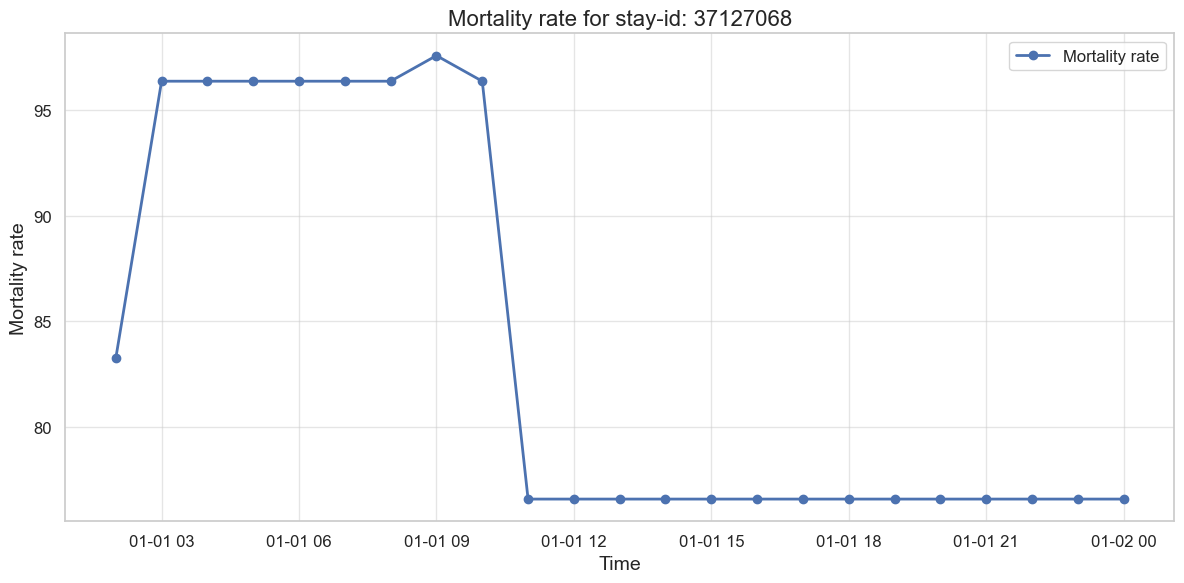

In [148]:
sns.set_theme(style="whitegrid")

# Plot the time series graph for mortality rate
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['abs_event_time'], filtered_df['Mortality_rate'], marker='o', linestyle='-', color='b', linewidth=2, markersize=6, label='Mortality rate')
plt.title(f'Mortality rate for stay-id: {random_stay_id}', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Mortality rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()